# Quantum Dynamics and Quantum Control - Lattice Spin System

$$
\textbf{Hugo Alexandre} \\
\text{M2 CompuPhys, Université Franche-Comté (UFC)} \\
\text{Supervisor: Bruno Bellomo}
$$


Note : If the code does not run successfully on the first attempt or if an error message appears, please try executing it again. It may not work initially (this has happened to me before). Additionally, ensure that all necessary libraries are installed in your environment to guarantee the code functions properly.



In [6]:
import numpy as np
import scipy as sp
import sympy as smp
from numpy import linalg as la
import matplotlib.pyplot as plt
from numpy import linalg as LA;
from scipy import linalg as LA2;
from numpy import random as rand
from scipy.sparse import diags
from numpy.linalg import norm, eigvals
from scipy.linalg import eigh
from scipy.linalg import expm


In [7]:
def tensorvect(a,b):
    return(np.tensordot(a,b,axes=0).flatten())

def tensorvectop(a,b):
    return LA2.kron(a,b)

def opchain(a,i,nspin):
    if i==1:
        return LA2.kron(a,np.identity(2**(nspin-1)))
    else:
        if i==nspin:
            return LA2.kron(np.identity(2**(nspin-1)),a)
        else:
            return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),np.identity(2**(nspin-i)))
        
def opchain2(a,i,b,j,nspin):
    if i==1:
        if j==nspin:
            return LA2.kron(LA2.kron(a,np.identity(2**(nspin-2))),b)
        else:
            return LA2.kron(LA2.kron(a,np.identity(2**(j-2))),LA2.kron(b,np.identity(2**(nspin-j))))      
    else:
        if j==nspin:
            return LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(nspin-(i+1))),b))
        else:
            return LA2.kron(LA2.kron(LA2.kron(np.identity(2**(i-1)),a),LA2.kron(np.identity(2**(j-(i+1))),b)),np.identity(2**(nspin-j)))
            
def buildstate(bin):
    v=[0. for i in range(2**len(bin))];
    v[int(bin,2)]=1.
    return np.array(v)


def diracrep(psi,nspin):
    state='';
    for i in range(2**nspin):
        if abs(psi[i])>10**(-3):
            state=state+'+'+str(round(np.abs(psi[i]), 3))+'|'+format(i,'0'+str(nspin)+'b')+'>'
    return state


def binnum(n):
    l=['0','1'];
    if n==1:
        return l
    else:
        return ['0'+i for i in binnum(n-1)]+['1'+i for i in binnum(n-1)]
    
def densmat(psi,i,nspin):
    if i>1:
        listindex0=binnum(i-1)
        listindex0=[j+'0' for j in listindex0]
    else:
        listindex0=['0']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex0=list(np.array([[j+k for k in listcomp] for j in listindex0]).flatten())
    if i>1:
        listindex1=binnum(i-1)
        listindex1=[j+'1' for j in listindex1]
    else:
        listindex1=['1']
    if i<nspin:
        listcomp=binnum(nspin-i)
        listindex1=list(np.array([[j+k for k in listcomp] for j in listindex1]).flatten())
    rho00=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex0)
    rho11=sum(psi[int(j,2)]*np.conjugate(psi[int(j,2)]) for j in listindex1)
    rho01=sum(psi[int(j,2)]*np.conjugate(psi[int(listindex1[listindex0.index(j)],2)]) for j in listindex0)
    return np.array([[rho00,rho01],[np.conjugate(rho01),rho11]])

def avdensmat(psi,nspin):
    rho=densmat(psi,1,nspin);
    if nspin>1:
        for i in range(2,nspin+1):
            rho=rho+densmat(psi,i,nspin)
    rho=rho/nspin;
    return rho

def purity(rho):
    rho2 = np.dot(rho,rho)
    tr = np.trace(rho2)
    return(np.real(tr))

def SvN(rho):
    vp=np.real(LA.eigvals(rho));
    S=0.;
    for i in range(len(vp)):
        if vp[i]>0.:
            S=S+vp[i]*np.log(vp[i])
    return -S

def entangl(psi,nspin):
    S=SvN(densmat(psi,1,nspin));
    if nspin>1:
        for i in range(2,nspin+1):
            S=S+SvN(densmat(psi,i,nspin))
    return S/nspin

def Disorder(psi,nspin):
    return SvN(avdensmat(psi,nspin))-entangl(psi,nspin)

$\Large{\textbf{Chapter 2 - Hamiltonians and eigenstates of lattice spin systems}}$

In this chapter, we aim to compute and study the eigenstates of lattice spin systems, particularly focusing on the ground state, which represents the steady state of the system at very low temperatures.

$\large{\textbf{2.1 - Studied models}}$

We will study several spin chain models characterized by parameters $N$, defined as $\textit{Nspin}$ in the code (which corresponds to the number of spins), $\omega$ the Larmor frequency and $J$ the exchange integral that models the strengths of the spin-spin interaction between neighbors in the three spatial directions.



In [8]:
sigX=np.array([[0.,1.],[1.,0.]]);
sigY=np.array([[0.,-1j],[1j,0.]]);
sigZ=np.array([[1.,0.],[0.,-1.]]);
sig1=np.array([[1.,0.],[0.,0.]]);
id2 =np.array([[1.,0.],[0.,1.]]);

NOT=sigX;
HAD1=np.array([[1./np.sqrt(2.),1./np.sqrt(2.)],[1./np.sqrt(2.),-1./np.sqrt(2.)]]);
CNOT=np.array([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,0.,1.],[0.,0.,1.,0.]]);
HAD2=np.array([[0.5,0.5,0.5,0.5],[0.5,-0.5,0.5,-0.5],[0.5,0.5,-0.5,-0.5],[0.5,-0.5,-0.5,0.5]]);
SWAP=np.array([[1.,0.,0.,0.],[0.,0.,1.,0.],[0.,1.,0.,0.],[0.,0.,0.,1.]]);

Sx = 1/2 * sigX
Sy = 1/2 * sigY
Sz = 1/2 * sigZ

The goal in this subpart is to write a Python code that constructs the total Hamiltonian of size $2^N \times 2^N$ for $N=\{2,3,8\}$ for each model, such that $H_{tot}=H_0+H_{int}$, where $H_0$ is the free Hamiltonian and $H_{int}$ is the interaction Hamiltonian.

$\textbf{- (1) Open Izing-Z spin chain}$

In [9]:
# Initialisation de l'affichage LaTeX
smp.init_printing(use_latex=True)

# Constantes
w = 0.5
J = 1
h0 = -w * sig1

# Définir les fonctions pour H0, Hint, et Htot
def H0(n):
    return np.sum([opchain(h0, i, n) for i in range(1, n+1)], axis=0)

def Hint_1(n):
    return -J * np.sum([opchain2(Sz, i, Sz, i + 1, n) for i in range(1, n)], axis=0)

def Htot_1(n):
    return H0(n) + Hint_1(n)

Htot1_2 = smp.Matrix(Htot_1(2))
Htot1_3 = smp.Matrix(Htot_1(3))

print("\033[1mHamiltonian H_tot1 for N=2:\033[0m")
display(Htot1_2)

print("\n")

print("\033[1mHamiltonian H_tot1 for N=3:\033[0m")
display(Htot1_3)

print("\n")

print("\033[1mHamiltonian H_tot1 for N=8:\033[0m")
print(sp.sparse.csr_matrix(Htot_1(8)))


Hamiltonian H_tot1 for N=2:


⎡-1.25    0      0      0  ⎤
⎢                          ⎥
⎢  0    -0.25    0      0  ⎥
⎢                          ⎥
⎢  0      0    -0.25    0  ⎥
⎢                          ⎥
⎣  0      0      0    -0.25⎦



Hamiltonian H_tot1 for N=3:


⎡-2.0   0     0     0     0    0   0     0  ⎤
⎢                                           ⎥
⎢ 0    -1.0   0     0     0    0   0     0  ⎥
⎢                                           ⎥
⎢ 0     0    -0.5   0     0    0   0     0  ⎥
⎢                                           ⎥
⎢ 0     0     0    -0.5   0    0   0     0  ⎥
⎢                                           ⎥
⎢ 0     0     0     0    -1.0  0   0     0  ⎥
⎢                                           ⎥
⎢ 0     0     0     0     0    0   0     0  ⎥
⎢                                           ⎥
⎢ 0     0     0     0     0    0  -0.5   0  ⎥
⎢                                           ⎥
⎣ 0     0     0     0     0    0   0    -0.5⎦



Hamiltonian H_tot1 for N=8:
  (0, 0)	-5.75
  (1, 1)	-4.75
  (2, 2)	-4.25
  (3, 3)	-4.25
  (4, 4)	-4.25
  (5, 5)	-3.25
  (6, 6)	-3.75
  (7, 7)	-3.75
  (8, 8)	-4.25
  (9, 9)	-3.25
  (10, 10)	-2.75
  (11, 11)	-2.75
  (12, 12)	-3.75
  (13, 13)	-2.75
  (14, 14)	-3.25
  (15, 15)	-3.25
  (16, 16)	-4.25
  (17, 17)	-3.25
  (18, 18)	-2.75
  (19, 19)	-2.75
  (20, 20)	-2.75
  (21, 21)	-1.75
  (22, 22)	-2.25
  (23, 23)	-2.25
  (24, 24)	-3.75
  :	:
  (231, 231)	-1.75
  (232, 232)	-2.25
  (233, 233)	-1.25
  (234, 234)	-0.75
  (235, 235)	-0.75
  (236, 236)	-1.75
  (237, 237)	-0.75
  (238, 238)	-1.25
  (239, 239)	-1.25
  (240, 240)	-3.25
  (241, 241)	-2.25
  (242, 242)	-1.75
  (243, 243)	-1.75
  (244, 244)	-1.75
  (245, 245)	-0.75
  (246, 246)	-1.25
  (247, 247)	-1.25
  (248, 248)	-2.75
  (249, 249)	-1.75
  (250, 250)	-1.25
  (251, 251)	-1.25
  (252, 252)	-2.25
  (253, 253)	-1.25
  (254, 254)	-1.75
  (255, 255)	-1.75


$\textbf{- (2) closed Izing-Z spin chain}$

In [10]:
def Hint_2(n):
    Hint = -J * np.sum([opchain2(Sz, i, Sz, i + 1, n) for i in range(1, n)], axis=0) # along Sz
    Hint += -J * opchain2(Sz, 1, Sz, n, n) # interaction with first and last
    return Hint

def Htot_2(n):
    return H0(n) + Hint_2(n)

Htot2_2 = smp.Matrix(Htot_2(2))
Htot2_3 = smp.Matrix(Htot_2(3))

print("\033[1mHamiltonian H_tot2 for N=2:\033[0m")
display(Htot2_2)

print("\n")

print("\033[1mHamiltonian H_tot2 for N=3:\033[0m")
display(Htot2_3)

print("\n")

print("\033[1mHamiltonian H_tot2 for N=8:\033[0m")
print(sp.sparse.csr_matrix(Htot_2(8)))

Hamiltonian H_tot2 for N=2:


⎡-1.5  0  0   0  ⎤
⎢                ⎥
⎢ 0    0  0   0  ⎥
⎢                ⎥
⎢ 0    0  0   0  ⎥
⎢                ⎥
⎣ 0    0  0  -0.5⎦



Hamiltonian H_tot2 for N=3:


⎡-2.25    0      0      0      0      0      0      0  ⎤
⎢                                                      ⎥
⎢  0    -0.75    0      0      0      0      0      0  ⎥
⎢                                                      ⎥
⎢  0      0    -0.75    0      0      0      0      0  ⎥
⎢                                                      ⎥
⎢  0      0      0    -0.25    0      0      0      0  ⎥
⎢                                                      ⎥
⎢  0      0      0      0    -0.75    0      0      0  ⎥
⎢                                                      ⎥
⎢  0      0      0      0      0    -0.25    0      0  ⎥
⎢                                                      ⎥
⎢  0      0      0      0      0      0    -0.25    0  ⎥
⎢                                                      ⎥
⎣  0      0      0      0      0      0      0    -0.75⎦



Hamiltonian H_tot2 for N=8:
  (0, 0)	-6.0
  (1, 1)	-4.5
  (2, 2)	-4.5
  (3, 3)	-4.0
  (4, 4)	-4.5
  (5, 5)	-3.0
  (6, 6)	-4.0
  (7, 7)	-3.5
  (8, 8)	-4.5
  (9, 9)	-3.0
  (10, 10)	-3.0
  (11, 11)	-2.5
  (12, 12)	-4.0
  (13, 13)	-2.5
  (14, 14)	-3.5
  (15, 15)	-3.0
  (16, 16)	-4.5
  (17, 17)	-3.0
  (18, 18)	-3.0
  (19, 19)	-2.5
  (20, 20)	-3.0
  (21, 21)	-1.5
  (22, 22)	-2.5
  (23, 23)	-2.0
  (24, 24)	-4.0
  :	:
  (231, 231)	-2.0
  (232, 232)	-2.0
  (233, 233)	-1.5
  (234, 234)	-0.5
  (235, 235)	-1.0
  (236, 236)	-1.5
  (237, 237)	-1.0
  (238, 238)	-1.0
  (239, 239)	-1.5
  (240, 240)	-3.0
  (241, 241)	-2.5
  (242, 242)	-1.5
  (243, 243)	-2.0
  (244, 244)	-1.5
  (245, 245)	-1.0
  (246, 246)	-1.0
  (247, 247)	-1.5
  (248, 248)	-2.5
  (249, 249)	-2.0
  (250, 250)	-1.0
  (251, 251)	-1.5
  (252, 252)	-2.0
  (253, 253)	-1.5
  (254, 254)	-1.5
  (255, 255)	-2.0


$\textbf{- (3) open Izing-X spin chain}$

In [11]:
def Hint_3(n):
    Hint = -J * np.sum([opchain2(Sx, i, Sx, i + 1, n) for i in range(1, n)], axis=0) # along Sx
    return Hint

def Htot_3(n):
    return H0(n) + Hint_3(n)

Htot3_2 = smp.Matrix(Htot_3(2))
Htot3_3 = smp.Matrix(Htot_3(3))

print("\033[1mHamiltonian H_tot3 for N=2:\033[0m")
display(Htot3_2)

print("\n")

print("\033[1mHamiltonian H_tot3 for N=3:\033[0m")
display(Htot3_3)

print("\n")

print("\033[1mHamiltonian H_tot3 for N=8:\033[0m")
print(sp.sparse.csr_matrix(Htot_3(8)))


Hamiltonian H_tot3 for N=2:


⎡-1.0     0      0    -0.25⎤
⎢                          ⎥
⎢  0    -0.5   -0.25    0  ⎥
⎢                          ⎥
⎢  0    -0.25  -0.5     0  ⎥
⎢                          ⎥
⎣-0.25    0      0      0  ⎦



Hamiltonian H_tot3 for N=3:


⎡-1.5     0      0    -0.25    0      0    -0.25    0  ⎤
⎢                                                      ⎥
⎢  0    -1.0   -0.25    0      0      0      0    -0.25⎥
⎢                                                      ⎥
⎢  0    -0.25  -1.0     0    -0.25    0      0      0  ⎥
⎢                                                      ⎥
⎢-0.25    0      0    -0.5     0    -0.25    0      0  ⎥
⎢                                                      ⎥
⎢  0      0    -0.25    0    -1.0     0      0    -0.25⎥
⎢                                                      ⎥
⎢  0      0      0    -0.25    0    -0.5   -0.25    0  ⎥
⎢                                                      ⎥
⎢-0.25    0      0      0      0    -0.25  -0.5     0  ⎥
⎢                                                      ⎥
⎣  0    -0.25    0      0    -0.25    0      0      0  ⎦



Hamiltonian H_tot3 for N=8:
  (0, 0)	-4.0
  (0, 3)	-0.25
  (0, 6)	-0.25
  (0, 12)	-0.25
  (0, 24)	-0.25
  (0, 48)	-0.25
  (0, 96)	-0.25
  (0, 192)	-0.25
  (1, 1)	-3.5
  (1, 2)	-0.25
  (1, 7)	-0.25
  (1, 13)	-0.25
  (1, 25)	-0.25
  (1, 49)	-0.25
  (1, 97)	-0.25
  (1, 193)	-0.25
  (2, 1)	-0.25
  (2, 2)	-3.5
  (2, 4)	-0.25
  (2, 14)	-0.25
  (2, 26)	-0.25
  (2, 50)	-0.25
  (2, 98)	-0.25
  (2, 194)	-0.25
  (3, 0)	-0.25
  :	:
  (252, 252)	-1.0
  (252, 255)	-0.25
  (253, 61)	-0.25
  (253, 157)	-0.25
  (253, 205)	-0.25
  (253, 229)	-0.25
  (253, 241)	-0.25
  (253, 251)	-0.25
  (253, 253)	-0.5
  (253, 254)	-0.25
  (254, 62)	-0.25
  (254, 158)	-0.25
  (254, 206)	-0.25
  (254, 230)	-0.25
  (254, 242)	-0.25
  (254, 248)	-0.25
  (254, 253)	-0.25
  (254, 254)	-0.5
  (255, 63)	-0.25
  (255, 159)	-0.25
  (255, 207)	-0.25
  (255, 231)	-0.25
  (255, 243)	-0.25
  (255, 249)	-0.25
  (255, 252)	-0.25


$\textbf{- (4) Open Heisenberg XXX-chain}$

In [12]:
def Hint_4(n):
    Hint = -J * np.sum([opchain2(Sx, i, Sx, i + 1, n) + opchain2(Sy, i, Sy, i + 1, n) 
                    + opchain2(Sz, i, Sz, i + 1, n) for i in range(1, n)], axis=0)
    return np.real(Hint) # along Sx + Sy + Sz

def Htot_4(n):
    return H0(n) + Hint_4(n)


Htot4_2 = smp.Matrix(Htot_4(2))
Htot4_3 = smp.Matrix(Htot_4(3))

print("\033[1mHamiltonian H_tot4 for N=2:\033[0m")
display(Htot4_2)

print("\n")

print("\033[1mHamiltonian H_tot4 for N=3:\033[0m")
display(Htot4_3)

print("\n")

print("\033[1mHamiltonian H_tot4 for N=8:\033[0m")
print(sp.sparse.csr_matrix(Htot_4(8)))

Hamiltonian H_tot4 for N=2:


⎡-1.25    0      0      0  ⎤
⎢                          ⎥
⎢  0    -0.25  -0.5     0  ⎥
⎢                          ⎥
⎢  0    -0.5   -0.25    0  ⎥
⎢                          ⎥
⎣  0      0      0    -0.25⎦



Hamiltonian H_tot4 for N=3:


⎡-2.0   0     0     0     0     0     0     0  ⎤
⎢                                              ⎥
⎢ 0    -1.0  -0.5   0     0     0     0     0  ⎥
⎢                                              ⎥
⎢ 0    -0.5  -0.5   0    -0.5   0     0     0  ⎥
⎢                                              ⎥
⎢ 0     0     0    -0.5   0    -0.5   0     0  ⎥
⎢                                              ⎥
⎢ 0     0    -0.5   0    -1.0   0     0     0  ⎥
⎢                                              ⎥
⎢ 0     0     0    -0.5   0     0    -0.5   0  ⎥
⎢                                              ⎥
⎢ 0     0     0     0     0    -0.5  -0.5   0  ⎥
⎢                                              ⎥
⎣ 0     0     0     0     0     0     0    -0.5⎦



Hamiltonian H_tot4 for N=8:
  (0, 0)	-5.75
  (1, 1)	-4.75
  (1, 2)	-0.5
  (2, 1)	-0.5
  (2, 2)	-4.25
  (2, 4)	-0.5
  (3, 3)	-4.25
  (3, 5)	-0.5
  (4, 2)	-0.5
  (4, 4)	-4.25
  (4, 8)	-0.5
  (5, 3)	-0.5
  (5, 5)	-3.25
  (5, 6)	-0.5
  (5, 9)	-0.5
  (6, 5)	-0.5
  (6, 6)	-3.75
  (6, 10)	-0.5
  (7, 7)	-3.75
  (7, 11)	-0.5
  (8, 4)	-0.5
  (8, 8)	-4.25
  (8, 16)	-0.5
  (9, 5)	-0.5
  (9, 9)	-3.25
  :	:
  (246, 246)	-1.25
  (246, 250)	-0.5
  (247, 239)	-0.5
  (247, 247)	-1.25
  (247, 251)	-0.5
  (248, 244)	-0.5
  (248, 248)	-2.75
  (249, 245)	-0.5
  (249, 249)	-1.75
  (249, 250)	-0.5
  (250, 246)	-0.5
  (250, 249)	-0.5
  (250, 250)	-1.25
  (250, 252)	-0.5
  (251, 247)	-0.5
  (251, 251)	-1.25
  (251, 253)	-0.5
  (252, 250)	-0.5
  (252, 252)	-2.25
  (253, 251)	-0.5
  (253, 253)	-1.25
  (253, 254)	-0.5
  (254, 253)	-0.5
  (254, 254)	-1.75
  (255, 255)	-1.75


$\textbf{- (5) Open Heisenberg XYZ-chain}$

In [13]:
def Hint_5(n):
    J = [0.5, 1., 1.5]
    Hint = -np.sum([J[0]*opchain2(Sx, i, Sx, i + 1, n) + J[1]*opchain2(Sy, i, Sy, i + 1, n) 
                    + J[2]*opchain2(Sz, i, Sz, i + 1, n) for i in range(1, n)], axis=0)
    return np.real(Hint) # along Sx + Sy + Sz

def Htot_5(n):
    return H0(n) + Hint_5(n)


Htot5_2 = smp.Matrix(Htot_5(2))
Htot5_3 = smp.Matrix(Htot_5(3))

print("\033[1mHamiltonian H_tot5 for N=2:\033[0m")
display(Htot5_2)

print("\n")

print("\033[1mHamiltonian H_tot5 for N=3:\033[0m")
display(Htot5_3)

print("\n")

print("\033[1mHamiltonian H_tot5 for N=8:\033[0m")
print(sp.sparse.csr_matrix(Htot_5(8)))

Hamiltonian H_tot5 for N=2:


⎡-1.375    0       0     0.125 ⎤
⎢                              ⎥
⎢  0     -0.125  -0.375    0   ⎥
⎢                              ⎥
⎢  0     -0.375  -0.125    0   ⎥
⎢                              ⎥
⎣0.125     0       0     -0.375⎦



Hamiltonian H_tot5 for N=3:


⎡-2.25    0       0     0.125     0       0     0.125     0  ⎤
⎢                                                            ⎥
⎢  0     -1.0   -0.375    0       0       0       0     0.125⎥
⎢                                                            ⎥
⎢  0    -0.375  -0.25     0     -0.375    0       0       0  ⎥
⎢                                                            ⎥
⎢0.125    0       0      -0.5     0     -0.375    0       0  ⎥
⎢                                                            ⎥
⎢  0      0     -0.375    0      -1.0     0       0     0.125⎥
⎢                                                            ⎥
⎢  0      0       0     -0.375    0      0.25   -0.375    0  ⎥
⎢                                                            ⎥
⎢0.125    0       0       0       0     -0.375   -0.5     0  ⎥
⎢                                                            ⎥
⎣  0    0.125     0       0     0.125     0       0     -0.75⎦



Hamiltonian H_tot5 for N=8:
  (0, 0)	-6.625
  (0, 3)	0.125
  (0, 6)	0.125
  (0, 12)	0.125
  (0, 24)	0.125
  (0, 48)	0.125
  (0, 96)	0.125
  (0, 192)	0.125
  (1, 1)	-5.375
  (1, 2)	-0.375
  (1, 7)	0.125
  (1, 13)	0.125
  (1, 25)	0.125
  (1, 49)	0.125
  (1, 97)	0.125
  (1, 193)	0.125
  (2, 1)	-0.375
  (2, 2)	-4.625
  (2, 4)	-0.375
  (2, 14)	0.125
  (2, 26)	0.125
  (2, 50)	0.125
  (2, 98)	0.125
  (2, 194)	0.125
  (3, 0)	0.125
  :	:
  (252, 255)	0.125
  (253, 61)	0.125
  (253, 157)	0.125
  (253, 205)	0.125
  (253, 229)	0.125
  (253, 241)	0.125
  (253, 251)	-0.375
  (253, 253)	-1.625
  (253, 254)	-0.375
  (254, 62)	0.125
  (254, 158)	0.125
  (254, 206)	0.125
  (254, 230)	0.125
  (254, 242)	0.125
  (254, 248)	0.125
  (254, 253)	-0.375
  (254, 254)	-2.375
  (255, 63)	0.125
  (255, 159)	0.125
  (255, 207)	0.125
  (255, 231)	0.125
  (255, 243)	0.125
  (255, 249)	0.125
  (255, 252)	0.125
  (255, 255)	-2.625


$\textbf{- (6) Random open Ising X chain}$

In [14]:
def Hint_6(n):
    J = np.random.uniform(-1, 1, n-1)
    Hint = -np.sum([J[i-1]*opchain2(Sx, i, Sx, i + 1, n) + J[i-1]*opchain2(Sy, i, Sy, i + 1, n) 
                    + J[i-1]*opchain2(Sz, i, Sz, i + 1, n) for i in range(1, n)], axis=0)
    return np.real(Hint) # along Sx + Sy + Sz

def H0_6(n):
    w = np.random.uniform(0, 0.5, n)
    return np.sum([opchain(-w[i-1]*sig1, i, n) for i in range(1, n+1)], axis=0)


def Htot_6(n):
    return np.round(H0_6(n) + Hint_6(n),4)

Htot6_2 = smp.Matrix(Htot_6(2))
Htot6_3 = smp.Matrix(Htot_6(3))

print("\033[1mHamiltonian H_tot6 for N=2:\033[0m")
display(Htot6_2)

print("\n")

print("\033[1mHamiltonian H_tot6 for N=3:\033[0m")
display(Htot6_3)

print("\n")

print("\033[1mHamiltonian H_tot6 for N=8:\033[0m")
print(sp.sparse.csr_matrix(Htot_6(8)))

Hamiltonian H_tot6 for N=2:


⎡-0.9401     0        0        0   ⎤
⎢                                  ⎥
⎢   0     -0.2468  -0.3778     0   ⎥
⎢                                  ⎥
⎢   0     -0.3778  -0.1266     0   ⎥
⎢                                  ⎥
⎣   0        0        0     -0.1889⎦



Hamiltonian H_tot6 for N=3:


⎡-0.6612     0        0        0        0        0        0       0   ⎤
⎢                                                                     ⎥
⎢   0     -0.5204  0.0531      0        0        0        0       0   ⎥
⎢                                                                     ⎥
⎢   0     0.0531   -0.6117     0     0.0365      0        0       0   ⎥
⎢                                                                     ⎥
⎢   0        0        0     -0.3646     0     0.0365      0       0   ⎥
⎢                                                                     ⎥
⎢   0        0     0.0365      0     -0.3249     0        0       0   ⎥
⎢                                                                     ⎥
⎢   0        0        0     0.0365      0     -0.1841  0.0531     0   ⎥
⎢                                                                     ⎥
⎢   0        0        0        0        0     0.0531   -0.2022    0   ⎥
⎢                                                               



Hamiltonian H_tot6 for N=8:
  (0, 0)	-1.8389
  (1, 1)	-1.9732
  (1, 2)	0.2175
  (2, 1)	0.2175
  (2, 2)	-1.3712
  (2, 4)	-0.3656
  (3, 3)	-1.0705
  (3, 5)	-0.3656
  (4, 2)	-0.3656
  (4, 4)	-1.0656
  (4, 8)	-0.3268
  (5, 3)	-0.3656
  (5, 5)	-1.1998
  (5, 6)	0.2175
  (5, 9)	-0.3268
  (6, 5)	0.2175
  (6, 6)	-1.329
  (6, 10)	-0.3268
  (7, 7)	-1.0284
  (7, 11)	-0.3268
  (8, 4)	-0.3268
  (8, 8)	-1.2891
  (8, 16)	0.023
  (9, 5)	-0.3268
  (9, 9)	-1.4234
  :	:
  (246, 246)	-0.1173
  (246, 250)	-0.3268
  (247, 239)	0.023
  (247, 247)	0.1833
  (247, 251)	-0.3268
  (248, 244)	-0.3268
  (248, 248)	-0.0314
  (249, 245)	-0.3268
  (249, 249)	-0.1656
  (249, 250)	0.2175
  (250, 246)	-0.3268
  (250, 249)	0.2175
  (250, 250)	0.4364
  (250, 252)	-0.3656
  (251, 247)	-0.3268
  (251, 251)	0.737
  (251, 253)	-0.3656
  (252, 250)	-0.3656
  (252, 252)	0.0883
  (253, 251)	-0.3656
  (253, 253)	-0.0459
  (253, 254)	0.2175
  (254, 253)	0.2175
  (254, 254)	-0.1751
  (255, 255)	0.1255


$\textbf{- (7) Spin Glass}$

In [15]:
def Hint_7(n):
    Jx = np.random.uniform(-1.0, 1.0, (n, n))
    Jy = np.random.uniform(-1.0, 1.0, (n, n))
    Jz = np.random.uniform(-1.0, 1.0, (n, n))
    
    Hint = np.sum([Jx[i, j] * opchain2(Sx, i+1, Sx, j+1, n) + 
                   Jy[i, j] * opchain2(Sy, i+1, Sy, j+1, n) + 
                   Jz[i, j] * opchain2(Sz, i+1, Sz, j+1, n)
                   for i in range(n-1) for j in range(i+1, n)], axis=0)
    
    return np.real(Hint)

def H0_7(n):
    w = np.random.uniform(0, 0.5, n)
    return np.sum([opchain(-w[i-1]*sig1, i, n) for i in range(1, n+1)], axis=0)


def Htot_7(n):
    return np.round(H0_7(n) + Hint_7(n), 4)


Htot7_2 = smp.Matrix(Htot_7(2))
Htot7_3 = smp.Matrix(Htot_7(3))

print("\033[1mHamiltonian H_tot7 for N=2:\033[0m")
display(Htot7_2)

print("\n")

print("\033[1mHamiltonian H_tot7 for N=3:\033[0m")
display(Htot7_3)

print("\n")

print("\033[1mHamiltonian H_tot7 for N=8:\033[0m")
print(sp.sparse.csr_matrix(Htot_7(8)))

Hamiltonian H_tot7 for N=2:


⎡-0.6067     0        0     0.2522⎤
⎢                                 ⎥
⎢   0     -0.5791  0.2029     0   ⎥
⎢                                 ⎥
⎢   0     0.2029   -0.4586    0   ⎥
⎢                                 ⎥
⎣0.2522      0        0     0.1437⎦



Hamiltonian H_tot7 for N=3:


⎡-0.4494    0        0     -0.1172     0     -0.084  0.0329     0   ⎤
⎢                                                                   ⎥
⎢   0     0.3949  0.3557      0     0.0254     0       0     0.0329 ⎥
⎢                                                                   ⎥
⎢   0     0.3557  -0.4403     0     0.2951     0       0     -0.084 ⎥
⎢                                                                   ⎥
⎢-0.1172    0        0     -0.1452     0     0.2951  0.0254     0   ⎥
⎢                                                                   ⎥
⎢   0     0.0254  0.2951      0     -0.3848    0       0     -0.1172⎥
⎢                                                                   ⎥
⎢-0.084     0        0     0.2951      0     -0.445  0.3557     0   ⎥
⎢                                                                   ⎥
⎢0.0329     0        0     0.0254      0     0.3557  0.4533     0   ⎥
⎢                                                                   ⎥
⎣   0     0.0329  -0



Hamiltonian H_tot7 for N=8:
  (0, 0)	-3.2251
  (0, 3)	-0.3659
  (0, 5)	0.2039
  (0, 6)	-0.3407
  (0, 9)	-0.0044
  (0, 10)	-0.3781
  (0, 12)	-0.1708
  (0, 17)	0.0593
  (0, 18)	0.3711
  (0, 20)	0.1403
  (0, 24)	-0.139
  (0, 33)	0.1088
  (0, 34)	0.1491
  (0, 36)	-0.1082
  (0, 40)	0.3702
  (0, 48)	0.0858
  (0, 65)	-0.0339
  (0, 66)	0.3187
  (0, 68)	0.4481
  (0, 72)	0.1103
  (0, 80)	0.0366
  (0, 96)	-0.1927
  (0, 129)	-0.4058
  (0, 130)	-0.1674
  (0, 132)	0.1769
  :	:
  (255, 123)	0.1769
  (255, 125)	-0.1674
  (255, 126)	-0.4058
  (255, 159)	-0.1927
  (255, 175)	0.0366
  (255, 183)	0.1103
  (255, 187)	0.4481
  (255, 189)	0.3187
  (255, 190)	-0.0339
  (255, 207)	0.0858
  (255, 215)	0.3702
  (255, 219)	-0.1082
  (255, 221)	0.1491
  (255, 222)	0.1088
  (255, 231)	-0.139
  (255, 235)	0.1403
  (255, 237)	0.3711
  (255, 238)	0.0593
  (255, 243)	-0.1708
  (255, 245)	-0.3781
  (255, 246)	-0.0044
  (255, 249)	-0.3407
  (255, 250)	0.2039
  (255, 252)	-0.3659
  (255, 255)	-0.8605


$\large{\textbf{2.2 - Diagonalization algorithms}}$

In this section, we are going to focus on diagonalization algorithms for computing the eigenvalues and eigenvectors of a Hamiltonian $H$ using the power method. This iterative technique focuses on identifying the largest eigenvalue of a Hamiltonian operator.

For the ground state, we apply the power method to a shifted matrix $H-\lambda I$ where $\lambda$ is a shift and $I$ is the identity. Starting with a normalized random complex vector, we iterate until convergence, ensuring that the resulting vector approximates the dominant eigenvector. The associated eigenvalue gives us the ground state energy.

To find the first excited state, we modify the power method by projecting the search vector orthogonally to the ground state, guiding the algorithm toward the second-largest eigenvalue. This approach efficiently identifies the ground state and the first excited state of a quantum system, facilitating the diagonalization of large Hamiltonians.

In [16]:
def ground_state(H, shift=None, kmax=1e6, eps=1e-8, verbose=True):
    # Set shift to a large positive value based on the maximum element of H, if not provided
    if shift is None:
        shift = int(abs(np.amax(H)) * 10)
    
    # Initialize a random complex vector normalized to 1
    phi = np.exp(1j * np.random.rand(H.shape[0]) * 2 * np.pi)  # Random vector with phase
    phi = phi / np.linalg.norm(phi)  # Normalize the vector to unit length
    
    # Apply the shift to the matrix H to help with convergence
    H_shifted = H - shift * np.eye(H.shape[0])  # Shifted Hamiltonian
    k = 0  # Initialize iteration counter
    
    # Power iteration method to find the dominant eigenvector
    while np.linalg.norm(H_shifted @ phi - (np.conj(phi) @ H_shifted @ phi) * phi) > eps and k <= kmax:
        # Update phi by applying the shifted Hamiltonian
        phi = H_shifted @ phi
        phi = phi / np.linalg.norm(phi)  # Normalize the vector
        k += 1  # Increment the iteration counter
    
    # Revert the matrix back to its original form by undoing the shift
    H_shifted += shift * np.eye(H.shape[0])
    
    # Compute the eigenvalue associated with the normalized vector phi
    eigenvalue = np.real(np.conj(phi) @ H @ phi)  # Rayleigh quotient for eigenvalue
    
    # Output the number of iterations if verbose mode is enabled
    if verbose:
        print(f"Converged in {k} iterations")
    
    return phi, eigenvalue  # Return the eigenvector and eigenvalue


def excited_state_1(H, phi0, shift=None, kmax=1e6, eps=1e-8):
    # Set a fixed shift value to help convergence if not provided
    if shift is None:
        shift = 100  
    
    # Initialize a random complex vector and normalize it
    phi = np.exp(1j * np.random.rand(H.shape[0]) * 2 * np.pi)  # Random vector with phase
    phi -= (np.conj(phi0) @ phi) * phi0  # Remove the component along the known ground state phi0
    phi /= np.linalg.norm(phi)  # Normalize the vector

    # Apply the shift to the Hamiltonian
    H_shifted = H - shift * np.eye(H.shape[0])  # Shifted Hamiltonian

    k = 0  # Initialize iteration counter
    # Power iteration to find the excited state
    while np.linalg.norm(H_shifted @ phi - (np.conj(phi) @ H_shifted @ phi) * phi) > eps and (k < kmax):
        # Update phi by applying the shifted Hamiltonian
        phi = H_shifted @ phi
        phi -= (np.conj(phi0) @ phi) * phi0  # Remove the component along the ground state
        phi /= np.linalg.norm(phi)  # Normalize the vector
        k += 1  # Increment the iteration counter

    print(f"Converged in {k} iterations")  # Output number of iterations

    # Calculate the eigenvalue associated with the excited state vector
    eigenvalue = np.real(np.conj(phi) @ H @ phi)  # Rayleigh quotient for eigenvalue

    # Return the eigenvalue and the excited state eigenvector
    return eigenvalue, phi


In [17]:
print("\033[1mFor model (3) with N=3 (Power Method)\033[0m")

# Obtain the ground state eigenvector and eigenvalue
vec_ground_3, val_ground_3 = ground_state(Htot_3(3))

# Print the ground state eigenvalue and Dirac representation of the eigenvector
print("Ground state eigenvalue:", round(val_ground_3, 3))
print("Ground state eigenvector (Dirac notation):", diracrep(vec_ground_3, 3))

print("\n") # new line

# Obtain the first excited state eigenvalue and eigenvector
val_excited_3, vec_excited_3 = excited_state_1(Htot_3(3), vec_ground_3)

# Print the first excited state eigenvalue and Dirac representation of the eigenvector
print("Excited state eigenvalue:", round(val_excited_3, 3))
print("Excited state eigenvector (Dirac notation):", diracrep(vec_excited_3, 3))

print("\n")
print("\n")

print("\033[1mFor model (3) with N=8 (Power Method)\033[0m")  # Title for N=8 case

# Obtain the ground state eigenvector and eigenvalue for N=8
vec_ground_8, val_ground_8 = ground_state(Htot_3(8))

# Print the ground state eigenvalue and Dirac representation of the eigenvector for N=8
print("Ground state eigenvalue:", round(val_ground_8, 3))
print("Ground state eigenvector (Dirac notation):", diracrep(vec_ground_8, 8))

print("\n")

# Obtain the first excited state eigenvalue and eigenvector for N=8
val_excited_8, vec_excited_8 = excited_state_1(Htot_3(8), vec_ground_8)

# Print the first excited state eigenvalue and Dirac representation of the eigenvector for N=8
print("Excited state eigenvalue:", round(val_excited_8, 3))
print("Excited state eigenvector (Dirac notation):", diracrep(vec_excited_8, 8))


For model (3) with N=3 (Power Method)
Converged in 110 iterations
Ground state eigenvalue: -1.623
Ground state eigenvector (Dirac notation): +0.939|000>+0.232|011>+0.103|101>+0.232|110>


Converged in 4824 iterations
Excited state eigenvalue: -1.401
Excited state eigenvector (Dirac notation): +0.521|001>+0.65|010>+0.521|100>+0.186|111>




For model (3) with N=8 (Power Method)
Converged in 796 iterations
Ground state eigenvalue: -4.459
Ground state eigenvector (Dirac notation): +0.752|00000000>+0.188|00000011>+0.094|00000101>+0.2|00000110>+0.058|00001001>+0.105|00001010>+0.202|00001100>+0.053|00001111>+0.04|00010001>+0.068|00010010>+0.108|00010100>+0.029|00010111>+0.203|00011000>+0.051|00011011>+0.028|00011101>+0.057|00011110>+0.029|00100001>+0.047|00100010>+0.07|00100100>+0.019|00100111>+0.108|00101000>+0.027|00101011>+0.016|00101101>+0.032|00101110>+0.202|00110000>+0.051|00110011>+0.026|00110101>+0.054|00110110>+0.018|00111001>+0.031|00111010>+0.058|00111100>+0.015|00111111>+0.021|01

In [18]:
def get_eigenvalues_eigenstates(matrix, N):
    # Compute eigenvalues and eigenvectors with the function taken from Scipy
    eigenvalues, eigenstates = eigh(matrix)

    # Select the first N eigenvalues and corresponding eigenstates
    return eigenvalues[:N], eigenstates[:, :N]


# Example usage
N = 2  # Change this value to get different N
eigenvalues_3, eigenstates_3 = get_eigenvalues_eigenstates(Htot_3(3), N)
eigenvalues_8, eigenstates_8 = get_eigenvalues_eigenstates(Htot_3(8), N)



text = ['Ground state', 'Excited state']


# Assuming nspin is the number of spins, which should correspond to the matrix size
nspin_3 = int(np.log2(Htot_3(3).shape[0]))  # Calculate the number of spins based on the matrix size
nspin_8 = int(np.log2(Htot_3(8).shape[0])) 

print("\033[1mFor model (3) with N=3 (Scipy Library)\033[0m")
# Print eigenstates in Dirac notation
for i in range(N):
    # Access the i-th eigenstate and pass it to diracrep
    print(f"Eigenvalues for {text[i]}:", round(eigenvalues_3[i],3))
    print(f"{text[i]} in Dirac notation: {diracrep(eigenstates_3[:, i], nspin_3)}\n")
    
print("\033[1mFor model (3) with N=8 (Scipy Library)\033[0m")
# Print eigenstates in Dirac notation
for i in range(N):
    # Access the i-th eigenstate and pass it to diracrep
    print(f"Eigenvalues for {text[i]}:", round(eigenvalues_8[i],3))
    print(f"{text[i]} in Dirac notation: {diracrep(eigenstates_8[:, i], nspin_8)}\n")


For model (3) with N=3 (Scipy Library)
Eigenvalues for Ground state: -1.623
Ground state in Dirac notation: +0.939|000>+0.232|011>+0.103|101>+0.232|110>

Eigenvalues for Excited state: -1.401
Excited state in Dirac notation: +0.521|001>+0.65|010>+0.521|100>+0.186|111>

For model (3) with N=8 (Scipy Library)
Eigenvalues for Ground state: -4.459
Ground state in Dirac notation: +0.752|00000000>+0.188|00000011>+0.094|00000101>+0.2|00000110>+0.058|00001001>+0.105|00001010>+0.202|00001100>+0.053|00001111>+0.04|00010001>+0.068|00010010>+0.108|00010100>+0.029|00010111>+0.203|00011000>+0.051|00011011>+0.028|00011101>+0.057|00011110>+0.029|00100001>+0.047|00100010>+0.07|00100100>+0.019|00100111>+0.108|00101000>+0.027|00101011>+0.016|00101101>+0.032|00101110>+0.202|00110000>+0.051|00110011>+0.026|00110101>+0.054|00110110>+0.018|00111001>+0.031|00111010>+0.058|00111100>+0.015|00111111>+0.021|01000001>+0.033|01000010>+0.047|01000100>+0.013|01000111>+0.068|01001000>+0.017|01001011>+0.01|01001101>+0.

When comparing the ground and excited states obtained using the Python library with those calculated via the power method, we observe $\textbf{identical coefficients}$. This consistency validates the accuracy and reliability of our numerical approach for determining eigenvalues and eigenstates.

Converged in 70 iterations


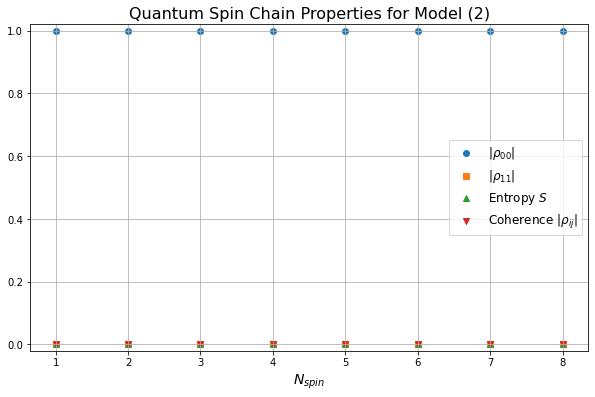

Von Neumann Entropy for model (2): SvN= 0.0
Purity for model (2): Purity= 1.0
Entanglement for model (2): Entanglement= 0.0
Disorder for model (2): Disorder= 0.0
Ground state vector for model (2) in Dirac notation: +1.0|00000000>


In [20]:
nspin = 8
# Call the renamed ground state function
ground_state_vector_2, ground_state_energy_2 = ground_state(Htot_2(nspin))

# Initialize lists to store results for each spin in the chain
rho_00, rho_11, S_VN, coherence = [], [], [], []

# Loop over each spin to calculate properties
for i in range(1, nspin + 1):
    rho_i = densmat(ground_state_vector_2, i, nspin)  # Calculate reduced density matrix for each spin
    rho_00.append(rho_i[0, 0])  # Probability of state |0⟩
    rho_11.append(rho_i[1, 1])  # Probability of state |1⟩
    S_VN.append(SvN(rho_i))     # Von Neumann entropy for each spin
    coherence.append(np.abs(rho_i[0, 1]) ** 2)  # Coherence term (|rho_01|^2) for each spin

# Convert lists to numpy arrays for easier plotting and data manipulation
rho_00 = np.array(rho_00)
rho_11 = np.array(rho_11)
S_VN = np.array(S_VN)
coherence = np.array(coherence)
SvN_mean_2 = SvN(avdensmat(ground_state_vector_2,nspin))
purity_value_2 = purity(densmat(ground_state_vector_2, 1, nspin))  # Calculate purity for the first spin
entanglement_value_2 = entangl(ground_state_vector_2, nspin)      # Calculate entanglement
disorder_value_2 = Disorder(ground_state_vector_2, nspin)         # Calculate disorder

# Plot the results for each property across the spin chain
plt.figure(figsize=(10, 6))
plt.scatter(range(1, nspin + 1), rho_00, label=r'$|\rho_{00}|$', marker='o')  # Plot population |0⟩
plt.scatter(range(1, nspin + 1), rho_11, label=r'$|\rho_{11}|$', marker='s')  # Plot population |1⟩
plt.scatter(range(1, nspin + 1), S_VN, label=r'Entropy $S$', marker='^')    # Plot entropy
plt.scatter(range(1, nspin + 1), coherence, label=r'Coherence $|\rho_{ij}|$', marker='v')  # Plot coherence

# Labeling the plot for clarity
plt.title("Quantum Spin Chain Properties for Model (2)", fontsize=16)
plt.xlabel(r'$N_{spin}$', fontsize=14)
plt.ylim(-0.02,1.02)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Print the results
print("\033[1mVon Neumann Entropy for model (2): SvN=\033[0m", round(SvN_mean_2, 3))
print("\033[1mPurity for model (2): Purity=\033[0m", round(purity_value_2, 3))
print("\033[1mEntanglement for model (2): Entanglement=\033[0m", round(entanglement_value_2, 3))
print("\033[1mDisorder for model (2): Disorder=\033[0m", round(disorder_value_2, 3))
print("\033[1mGround state vector for model (2) in Dirac notation:\033[0m", diracrep(ground_state_vector_2, nspin))




Converged in 761 iterations


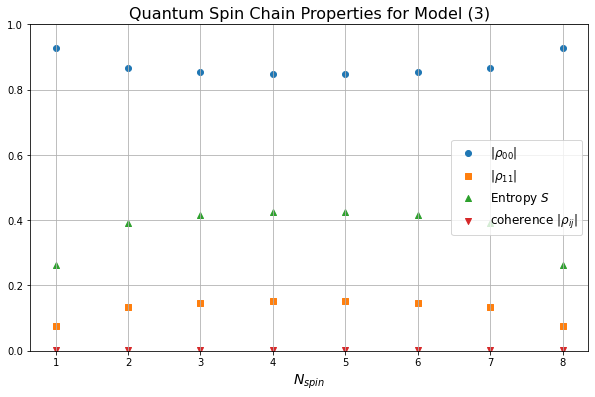

Von Neumann Entropy for model (3): SvN= 0.3788
Purity for model (3): Purity= 0.8634
Entanglement for model (3): Entanglement= 0.374
Disorder for model (3): Disorder= 0.0048
Ground state vector for model (3) in Dirac notation: +0.752|00000000>+0.188|00000011>+0.094|00000101>+0.2|00000110>+0.058|00001001>+0.105|00001010>+0.202|00001100>+0.053|00001111>+0.04|00010001>+0.068|00010010>+0.108|00010100>+0.029|00010111>+0.203|00011000>+0.051|00011011>+0.028|00011101>+0.057|00011110>+0.029|00100001>+0.047|00100010>+0.07|00100100>+0.019|00100111>+0.108|00101000>+0.027|00101011>+0.016|00101101>+0.032|00101110>+0.202|00110000>+0.051|00110011>+0.026|00110101>+0.054|00110110>+0.018|00111001>+0.031|00111010>+0.058|00111100>+0.015|00111111>+0.021|01000001>+0.033|01000010>+0.047|01000100>+0.013|01000111>+0.068|01001000>+0.017|01001011>+0.01|01001101>+0.02|01001110>+0.105|01010000>+0.026|01010011>+0.014|01010101>+0.028|01010110>+0.01|01011001>+0.018|01011010>+0.031|01011100>+0.008|01011111>+0.2|01100000

In [21]:
# Call the renamed ground state function
ground_state_vector_3, ground_state_energy_3 = ground_state(Htot_3(nspin))

# Initialize lists to store results
rho_00, rho_11, S_VN, coherence = [], [], [], []

for i in range(1, nspin + 1):
    rho_i = densmat(ground_state_vector_3, i, nspin)  # Calculate density matrix for each spin
    rho_00.append(rho_i[0, 0])
    rho_11.append(rho_i[1, 1])
    S_VN.append(SvN(rho_i))  # Von Neumann entropy for the spin
    coherence.append(np.abs(rho_i[0, 1]) ** 2)  # Calculate coherence term

# Convert lists to numpy arrays for easier manipulation
rho_00 = np.array(rho_00)
rho_11 = np.array(rho_11)
S_VN = np.array(S_VN)
coherence = np.array(coherence)
SvN_mean_3 = SvN(avdensmat(ground_state_vector_3,nspin))
purity_value_3 = purity(densmat(ground_state_vector_3, 1, nspin))  # Calculate purity for the first spin
entanglement_value_3 = entangl(ground_state_vector_3, nspin)      # Calculate entanglement
disorder_value_3 = Disorder(ground_state_vector_3, nspin)         # Calculate disorder

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(1, nspin + 1), rho_00, label=r'$|\rho_{00}|$', marker='o')
plt.scatter(range(1, nspin + 1), rho_11, label=r'$|\rho_{11}|$', marker='s')
plt.scatter(range(1, nspin + 1), S_VN, label=r'Entropy $S$', marker='^')
plt.scatter(range(1, nspin + 1), coherence, label=r'coherence $|\rho_{ij}|$', marker='v')
plt.ylim(0,1)
plt.title("Quantum Spin Chain Properties for Model (3)", fontsize=16)
plt.xlabel(r'$N_{spin}$', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Print the results
print("\033[1mVon Neumann Entropy for model (3): SvN=\033[0m", round(SvN_mean_3, 4))
print("\033[1mPurity for model (3): Purity=\033[0m", round(purity_value_3, 4))
print("\033[1mEntanglement for model (3): Entanglement=\033[0m", round(entanglement_value_3, 4))
print("\033[1mDisorder for model (3): Disorder=\033[0m", round(disorder_value_3, 4))
print("\033[1mGround state vector for model (3) in Dirac notation:\033[0m", diracrep(ground_state_vector_3, nspin))


Converged in 777 iterations


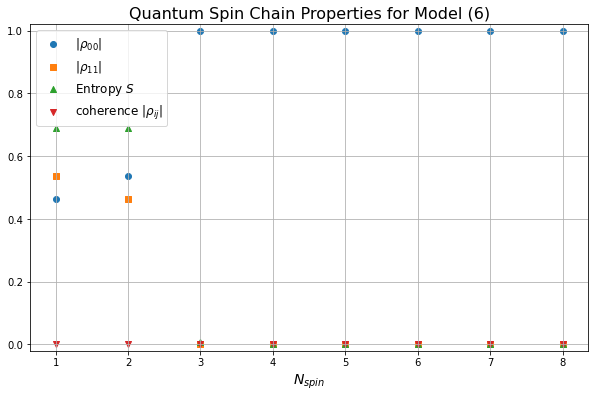

Von Neumann Entropy for model (6): SvN= 0.3768
Purity for model (6): Purity= 0.5025
Entanglement for model (6): Entanglement= 0.1738
Disorder for model (6): Disorder= 0.203
Ground state vector for model (6) in Dirac notation: +0.002|00001000>+0.01|00010000>+0.033|00100000>+0.681|01000000>+0.732|10000000>


In [22]:
# Call the renamed ground state function
ground_state_vector_6, ground_state_energy_6 = ground_state(Htot_6(nspin))

# Initialize lists to store results
rho_00, rho_11, S_VN, coherence = [], [], [], []

for i in range(1, nspin + 1):
    rho_i = densmat(ground_state_vector_6, i, nspin)  # Calculate density matrix for each spin
    rho_00.append(rho_i[0, 0])
    rho_11.append(rho_i[1, 1])
    S_VN.append(SvN(rho_i))  # Von Neumann entropy for the spin
    coherence.append(np.abs(rho_i[0, 1]) ** 2)  # Calculate coherence term

# Convert lists to numpy arrays for easier manipulation
rho_00 = np.array(rho_00)
rho_11 = np.array(rho_11)
S_VN = np.array(S_VN)
coherence = np.array(coherence)
SvN_mean_6 = SvN(avdensmat(ground_state_vector_6,nspin))
purity_value_6 = purity(densmat(ground_state_vector_6, 1, nspin))  # Calculate purity for the first spin
entanglement_value_6 = entangl(ground_state_vector_6, nspin)      # Calculate entanglement
disorder_value_6 = Disorder(ground_state_vector_6, nspin)         # Calculate disorder

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(range(1, nspin + 1), rho_00, label=r'$|\rho_{00}|$', marker='o')
plt.scatter(range(1, nspin + 1), rho_11, label=r'$|\rho_{11}|$', marker='s')
plt.scatter(range(1, nspin + 1), S_VN, label=r'Entropy $S$', marker='^')
plt.scatter(range(1, nspin + 1), coherence, label=r'coherence $|\rho_{ij}|$', marker='v')
plt.title("Quantum Spin Chain Properties for Model (6)", fontsize=16)
plt.xlabel(r'$N_{spin}$', fontsize=14)
plt.ylim(-0.02,1.02)
plt.legend(fontsize=12)
plt.grid()
plt.show()


# Print the results
print("\033[1mVon Neumann Entropy for model (6): SvN=\033[0m", round(SvN_mean_6, 4))
print("\033[1mPurity for model (6): Purity=\033[0m", round(purity_value_6, 4))
print("\033[1mEntanglement for model (6): Entanglement=\033[0m", round(entanglement_value_6, 4))
print("\033[1mDisorder for model (6): Disorder=\033[0m", round(disorder_value_6, 4))
print("\033[1mGround state vector for model (6) in Dirac notation:\033[0m", diracrep(ground_state_vector_6, nspin))

$\textbf{Analysis and comments}$

- $\textbf{For model (2)}$ : The results indicate that the ground state of the model (2) is pure, with no entanglement or disorder. The Von Neumann entropy is zero, confirming a fully coherent state, and the purity value of 1 indicates it is a pure state. The ground state is represented by $∣00000000⟩$, meaning all spins are aligned in the $∣0⟩$ state, which is highly ordered.


- $\textbf{For model (3)}$ : the results show a mixed state, unlike the pure state in the closed Ising-Z case. The Von Neumann entropy ($SvN = 0.3788$) indicates that there is some degree of quantum uncertainty in the system. The purity of $0.8634$ reflects a state that is not completely pure, meaning there is some mixedness in the system. The entanglement value of $0.374$ suggests the presence of quantum entanglement between the spins. Additionally, the disorder value is quite low, which indicates the system is not disordered but rather exhibits a relatively low level of randomness.


- $\textbf{For model (6)}$ : The results indicate that the system exhibits random interactions typical of the open Ising-X chain. Despite the randomness, the system's purity tends to remain close to $1$, suggesting that the state is nearly pure with slight mixedness. The Von Neumann entropy ($SvN$) usually falls between $0.3$ and $0.4$, indicating a moderate level of quantum uncertainty and mixedness in the state. This range reflects a system that is not fully coherent, yet not completely disordered either. The entanglement value suggests moderate entanglement between the spins, further emphasizing the quantum nature of the system. The disorder value is low, indicating that while there is randomness, the system is not highly disordered, maintaining some structure amidst the randomness.
    

$\large{\textbf{2.3 - Properties of the ground state}}$

In [23]:
def H0_w0(n):
    W = 0
    h_0 = -W * sig1
    H_0 = np.sum([opchain(h_0, i + 1, n) for i in range(1, n)], axis=0)
    return H_0

def Hint_J_open(n,J):
    H_int = -J * np.sum([opchain2(Sz, i, Sz, i + 1, n) for i in range(1, n)], axis=0)
    return H_int


# Define Htot_232 as the total Hamiltonian
def Htot_J_open(n,J):
    return H0_w0(n) + Hint_J_open(n, J)

H_ferro_open = Htot_J_open(8,1)
H_antiferro_open = Htot_J_open(8,-1)

# Calculate the ground state for the ferromagnetic model
vect_propre_ferro_open, val_propre_ferro_open = ground_state(H_ferro_open)

# Print the eigenvalue, Hamiltonian, and Dirac representation of the eigenvector for ferromagnetic case
print("\n\033[1mFerromagnetic Ising-Z Open Chain (J = 1)\033[0m")
print("\nHamiltonian for Ferromagnetic Ising-Z Open Chain:")
print(sp.sparse.csr_matrix(H_ferro_open))
print("\nEigenvalue: ", round(val_propre_ferro_open, 3))  
print("\nEigenstate (Dirac Representation):")
print(diracrep(vect_propre_ferro_open, 8))

# Calculate the ground state for the antiferromagnetic model
vect_propre_antiferro_open, val_propre_antiferro_open = ground_state(H_antiferro_open)

# Print the eigenvalue, Hamiltonian, and Dirac representation of the eigenvector for antiferromagnetic case
print("\n\033[1mAntiferromagnetic Ising-Z Open Chain (J = -1)\033[0m")
print("\nHamiltonian for Antiferromagnetic Ising-Z Open Chain:")
print(sp.sparse.csr_matrix(H_antiferro_open))
print("\nEigenvalue: ", round(val_propre_antiferro_open, 3))  
print("\nEigenstate (Dirac Representation):")
print(diracrep(vect_propre_antiferro_open, 8))

Converged in 692 iterations

Ferromagnetic Ising-Z Open Chain (J = 1)

Hamiltonian for Ferromagnetic Ising-Z Open Chain:
  (0, 0)	-1.75
  (1, 1)	-1.25
  (2, 2)	-0.75
  (3, 3)	-1.25
  (4, 4)	-0.75
  (5, 5)	-0.25
  (6, 6)	-0.75
  (7, 7)	-1.25
  (8, 8)	-0.75
  (9, 9)	-0.25
  (10, 10)	0.25
  (11, 11)	-0.25
  (12, 12)	-0.75
  (13, 13)	-0.25
  (14, 14)	-0.75
  (15, 15)	-1.25
  (16, 16)	-0.75
  (17, 17)	-0.25
  (18, 18)	0.25
  (19, 19)	-0.25
  (20, 20)	0.25
  (21, 21)	0.75
  (22, 22)	0.25
  (23, 23)	-0.25
  (24, 24)	-0.75
  :	:
  (231, 231)	-0.75
  (232, 232)	-0.25
  (233, 233)	0.25
  (234, 234)	0.75
  (235, 235)	0.25
  (236, 236)	-0.25
  (237, 237)	0.25
  (238, 238)	-0.25
  (239, 239)	-0.75
  (240, 240)	-1.25
  (241, 241)	-0.75
  (242, 242)	-0.25
  (243, 243)	-0.75
  (244, 244)	-0.25
  (245, 245)	0.25
  (246, 246)	-0.25
  (247, 247)	-0.75
  (248, 248)	-1.25
  (249, 249)	-0.75
  (250, 250)	-0.25
  (251, 251)	-0.75
  (252, 252)	-1.25
  (253, 253)	-0.75
  (254, 254)	-1.25
  (255, 255)	-1.75

Ei

In the $\textbf{ferromagnetic Ising-Z open chain}$, the spins in the ground state align in the same direction, either all up or all down. The eigenstate is a superposition of these configurations, $∣00000000⟩$ and $∣11111111⟩$, reflecting the preference for uniform spin alignment, typical of ferromagnetic materials. The ground state energy is degenerate, meaning both configurations have the same energy but all spins are oriented in the same direction.

In the $\textbf{antiferromagnetic Ising-Z open chain}$, the spins alternate between up and down. The eigenstate is a superposition of the alternating configurations, ∣01010101⟩ and ∣10101010⟩, which reflects the antiparallel arrangement of neighboring spins. This is characteristic of antiferromagnetic materials, where adjacent spins tend to point in opposite directions, minimizing the system's interaction energy.

In [24]:
def Hint_J_closed(n, J):
    # Interaction term for closed boundary conditions (including interaction with first and last spins)
    Hint = -J * np.sum([opchain2(Sz, i, Sz, i + 1, n) for i in range(1, n)], axis=0)  # along Sz
    Hint += -J * opchain2(Sz, 1, Sz, n, n)  # interaction between the first and last spin
    return Hint

# Define Htot_232 as the total Hamiltonian for closed chain
def Htot_J_closed(n, J):
    return H0_w0(n) + Hint_J_closed(n, J)

# Ferromagnetic and Antiferromagnetic Hamiltonians for the closed chain with 3 spins
H_ferro_closed = Htot_J_closed(3, 1)
H_antiferro_closed = Htot_J_closed(3, -1)

# Calculate the ground state for the ferromagnetic model
vect_propre_ferro_closed, val_propre_ferro_closed = ground_state(H_ferro_closed)

# Print the eigenvalue, Hamiltonian, and Dirac representation of the eigenvector for ferromagnetic closed chain
print("\n\033[1mFerromagnetic Ising-Z Closed Chain (J = 1)\033[0m")
print("\nHamiltonian for Ferromagnetic Ising-Z Closed Chain:")
print(H_ferro_closed)
print("\nEigenvalue: ", round(val_propre_ferro_closed, 3))  
print("\nEigenstate (Dirac Representation):")
print(diracrep(vect_propre_ferro_closed, 3))

# Calculate the ground state for the antiferromagnetic model
vect_propre_antiferro_closed, val_propre_antiferro_closed = ground_state(H_antiferro_closed)

# Print the eigenvalue, Hamiltonian, and Dirac representation of the eigenvector for antiferromagnetic closed chain
print("\n\033[1mAntiferromagnetic Ising-Z Closed Chain (J = -1)\033[0m")
print("\nHamiltonian for Antiferromagnetic Ising-Z Closed Chain:")
print(H_antiferro_closed)
print("\nEigenvalue: ", round(val_propre_antiferro_closed, 3))  
print("\nEigenstate (Dirac Representation):")
print(diracrep(vect_propre_antiferro_closed, 3))


Converged in 42 iterations

Ferromagnetic Ising-Z Closed Chain (J = 1)

Hamiltonian for Ferromagnetic Ising-Z Closed Chain:
[[-0.75  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.25  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.25  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.25  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.25  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.25  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.75]]

Eigenvalue:  -0.75

Eigenstate (Dirac Representation):
+0.707|000>+0.707|111>
Converged in 121 iterations

Antiferromagnetic Ising-Z Closed Chain (J = -1)

Hamiltonian for Antiferromagnetic Ising-Z Closed Chain:
[[ 0.75  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.25  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.25  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.25  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.25  0.    0.    0.  ]

In the $\textbf{ferromagnetic Ising-Z closed chain}$, the ground state shows all spins aligned, either all up or all down $(∣000⟩ and ∣111⟩)$, reflecting typical ferromagnetic behavior where neighboring spins align in the same direction. The closed boundary creates a loop, reinforcing this uniform alignment.

In the $\textbf{antiferromagnetic Ising-Z closed chain}$, the spins alternate between up and down, as seen in the eigenstate $∣001⟩+∣010⟩+∣011⟩+∣100⟩+∣101⟩+∣110⟩$, typical of antiferromagnetic materials where spins oppose each other. The closed boundary forces this alternating pattern.

Compared to the $\textbf{open chain}$, the main difference is the boundary condition. The closed chain enforces a relationship between the spins at the ends, creating more rigid spin configurations, while the open chain allows more flexibility at the boundaries, leading to different energy distributions and spin alignments.


$\textbf{Spin triangle & geometric frustration phenomenon}$

Geometric frustration in antiferromagnetic spin systems occurs when the lattice geometry prevents spins from aligning in a way that satisfies the interaction rules. In triangular or similar lattices, each spin is frustrated by its neighbors because it's impossible for all spins to be oppositely aligned simultaneously due to the geometry. This leads to a degenerate ground state with multiple possible configurations.

In the case of an $\textbf{antiferromagnetic triangular lattice}$, spins cannot fully align oppositely, resulting in a ground state with many possible configurations. This is called $\textbf{frustration}$.

For example, in materials like herbertsmithite, this frustration results in a quantum spin-liquid phase ($\textit{Frustrated Spin Systems by C.L. Henley}$ and $\textit{Introduction to Frustrated Magnetism by H.J. Lannert.}$)

$\large{\textbf{3.1 - Studied models}}$

In [25]:
def New_H0(n, w):
    h0 = -w*sig1
    H0 = np.sum([opchain(h0, i, n) for i in range(1, n+1)], axis=0)
    return H0

def Hint_XXX_open(n,J):
    Hint = -J * np.sum([opchain2(Sx, i, Sx, i + 1, n) + opchain2(Sy, i, Sy, i + 1, n) 
                    + opchain2(Sz, i, Sz, i + 1, n) for i in range(1, n)], axis=0)
    return np.real(Hint) # along Sx + Sy + Sz

def Htot_XXX_open(n,w,J):
    return New_H0(n,w) + Hint_XXX_open(n,J)


print("\033[1mHeisenberg-XXX open chain for N=7:\033[0m", "\n")
print(Htot_XXX_open(7,1,0.1), "\n")

print(sp.sparse.csr_matrix(Htot_XXX_open(7,1,0.1)))

Heisenberg-XXX open chain for N=7: 

[[-7.15  0.    0.   ...  0.    0.    0.  ]
 [ 0.   -6.1  -0.05 ...  0.    0.    0.  ]
 [ 0.   -0.05 -6.05 ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ... -1.05 -0.05  0.  ]
 [ 0.    0.    0.   ... -0.05 -1.1   0.  ]
 [ 0.    0.    0.   ...  0.    0.   -0.15]] 

  (0, 0)	-7.15
  (1, 1)	-6.1
  (1, 2)	-0.05
  (2, 1)	-0.05
  (2, 2)	-6.05
  (2, 4)	-0.05
  (3, 3)	-5.1
  (3, 5)	-0.05
  (4, 2)	-0.05
  (4, 4)	-6.05
  (4, 8)	-0.05
  (5, 3)	-0.05
  (5, 5)	-5.0
  (5, 6)	-0.05
  (5, 9)	-0.05
  (6, 5)	-0.05
  (6, 6)	-5.05
  (6, 10)	-0.05
  (7, 7)	-4.1
  (7, 11)	-0.05
  (8, 4)	-0.05
  (8, 8)	-6.05
  (8, 16)	-0.05
  (9, 5)	-0.05
  (9, 9)	-5.0
  :	:
  (118, 118)	-2.0
  (118, 122)	-0.05
  (119, 111)	-0.05
  (119, 119)	-1.05
  (119, 123)	-0.05
  (120, 116)	-0.05
  (120, 120)	-3.1
  (121, 117)	-0.05
  (121, 121)	-2.05
  (121, 122)	-0.05
  (122, 118)	-0.05
  (122, 121)	-0.05
  (122, 122)	-2.0
  (122, 124)	-0.05
  (123, 119)	-0.05
  (123, 123)	-1.05
  (123, 125)	-0.0

In [26]:
def Hint_XXX_closed(n):
    Hint = -0.1 * np.sum([opchain2(Sx, i, Sx, i + 1, n) + opchain2(Sy, i, Sy, i + 1, n) 
                    + opchain2(Sz, i, Sz, i + 1, n) for i in range(1, n)], axis=0)
    Hint += -0.1*(opchain2(Sx, 1, Sx, n, n) + opchain2(Sy, 1, Sy, n, n) + opchain2(Sz, 1, Sz, n, n))
    return np.real(Hint) # along Sx + Sy + Sz

def Htot_XXX_closed(n,w):
    return New_H0(n,w) + Hint_XXX_closed(n)


print("\033[1mHeisenberg-XXX closed chain for N=7:\033[0m", "\n")
print(Htot_XXX_closed(7,1), "\n")

print(sp.sparse.csr_matrix(Htot_XXX_closed(7,1)))



Heisenberg-XXX closed chain for N=7: 

[[-7.175  0.     0.    ...  0.     0.     0.   ]
 [ 0.    -6.075 -0.05  ...  0.     0.     0.   ]
 [ 0.    -0.05  -6.075 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ... -1.075 -0.05   0.   ]
 [ 0.     0.     0.    ... -0.05  -1.075  0.   ]
 [ 0.     0.     0.    ...  0.     0.    -0.175]] 

  (0, 0)	-7.175
  (1, 1)	-6.075
  (1, 2)	-0.05
  (1, 64)	-0.05
  (2, 1)	-0.05
  (2, 2)	-6.075
  (2, 4)	-0.05
  (3, 3)	-5.075
  (3, 5)	-0.05
  (3, 66)	-0.05
  (4, 2)	-0.05
  (4, 4)	-6.075
  (4, 8)	-0.05
  (5, 3)	-0.05
  (5, 5)	-4.975
  (5, 6)	-0.05
  (5, 9)	-0.05
  (5, 68)	-0.05
  (6, 5)	-0.05
  (6, 6)	-5.075
  (6, 10)	-0.05
  (7, 7)	-4.075
  (7, 11)	-0.05
  (7, 70)	-0.05
  (8, 4)	-0.05
  :	:
  (119, 123)	-0.05
  (120, 57)	-0.05
  (120, 116)	-0.05
  (120, 120)	-3.075
  (121, 117)	-0.05
  (121, 121)	-2.075
  (121, 122)	-0.05
  (122, 59)	-0.05
  (122, 118)	-0.05
  (122, 121)	-0.05
  (122, 122)	-1.975
  (122, 124)	-0.05
  (123, 119)	-0.05
  (123, 123)	-1.

In [27]:
def Hint_XXX_inhomogenous(n):
    Hint = -np.sum([0.5/i * (opchain2(Sx, i, Sx, i + 1, n) + opchain2(Sy, i, Sy, i + 1, n) 
                    + opchain2(Sz, i, Sz, i + 1, n)) for i in range(1, n)], axis=0)
    return np.real(Hint) # along Sx + Sy + Sz

def Htot_XXX_inhomogenous(n,w):
    return New_H0(n,w) + Hint_XXX_inhomogenous(n)

print("\033[1mInhomogenous Heisenberg-XXX open chain for N=7:\033[0m", "\n")
print(Htot_XXX_inhomogenous(7,1), "\n")

print(sp.sparse.csr_matrix(Htot_XXX_inhomogenous(7,1)))


Inhomogenous Heisenberg-XXX open chain for N=7: 

[[-7.30625     0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -6.26458333 -0.04166667 ...  0.          0.
   0.        ]
 [ 0.         -0.04166667 -6.21458333 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -1.21458333 -0.04166667
   0.        ]
 [ 0.          0.          0.         ... -0.04166667 -1.26458333
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.30625   ]] 

  (0, 0)	-7.30625
  (1, 1)	-6.264583333333333
  (1, 2)	-0.041666666666666664
  (2, 1)	-0.041666666666666664
  (2, 2)	-6.214583333333334
  (2, 4)	-0.05
  (3, 3)	-5.25625
  (3, 5)	-0.05
  (4, 2)	-0.05
  (4, 4)	-6.19375
  (4, 8)	-0.0625
  (5, 3)	-0.05
  (5, 5)	-5.152083333333334
  (5, 6)	-0.041666666666666664
  (5, 9)	-0.0625
  (6, 5)	-0.041666666666666664
  (6, 6)	-5.202083333333333
  (6, 10)	-0.0625
  (7, 7)	-4.24375
  (7, 11)	-0.0625
  (8, 4)	-0.0625
  (8, 8)	-6.160416666666666
  (8,

In [28]:
def Dyn(H,t,psi0):
    return LA2.expm(-1j*H*t) @ psi0


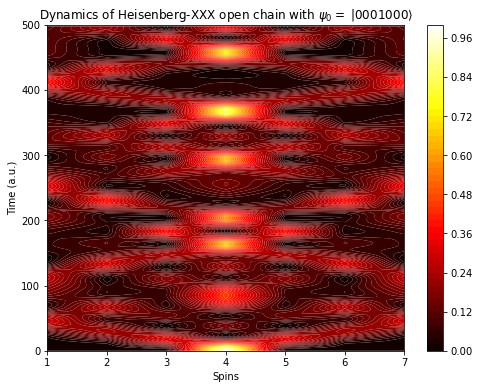

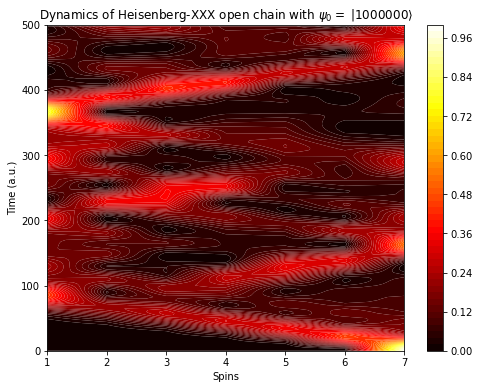

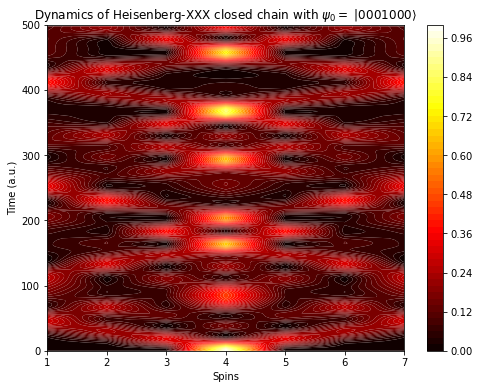

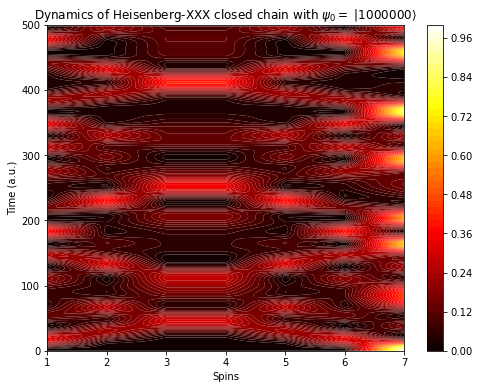

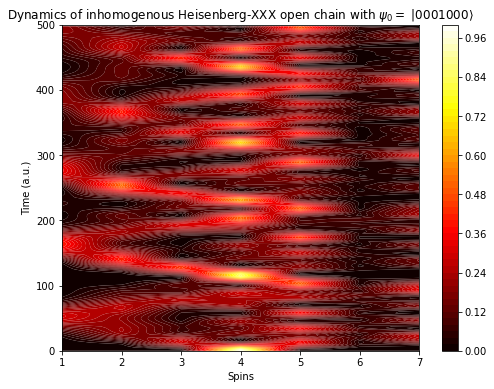

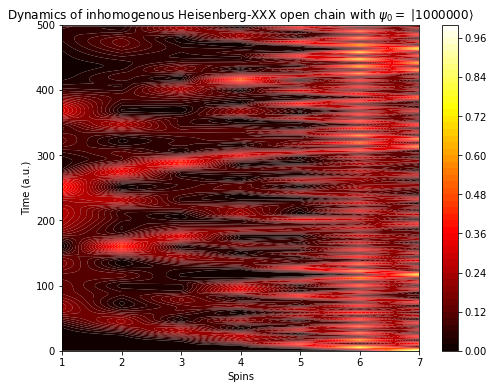

In [29]:
# Define the spin chain parameters
n_spin = 7           # Number of spins in the chain
N_time = 200         # Number of time steps
T = 500              # Total time
dt = T / N_time      # Time step

def plot_dynamics(model, T, nspin, psi0, state_label):
    # Simulation parameters
    dt = T / N_time
    
    # Initialize the population array
    pop = np.zeros((N_time, nspin))  # Array to store population over time

    # Time evolution
    for i in range(N_time):
        t = i * dt
        psi_t = Dyn(model.H, t, psi0)  # Evolve the wavefunction

        # Compute population for each spin
        rho_k = np.outer(psi_t, np.conj(psi_t))  # Full density matrix
        for k in range(nspin):
            pop[i, k] = rho_k[2**k, 2**k].real  # Only real part is stored

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.contourf(range(1, nspin + 1), [i * dt for i in range(N_time)], pop, 
                 levels=[i * 0.02 for i in range(51)], cmap='hot', antialiased=True)
    plt.xlabel("Spins")
    plt.ylabel("Time (a.u.)")
    plt.colorbar()
    plt.title(f'Dynamics of {model.name} with $\psi_0=$ |{state_label}⟩')
    plt.ylim(0,500)
    
    # Save the plot
    plt.savefig(f'graphpop_{model.name}_state_{state_label}.png')
    plt.show()

# List of models
models_3_1 = ['Heisenberg-XXX open chain', 'Heisenberg-XXX closed chain', 'inhomogenous Heisenberg-XXX open chain']

# Initial states with labels
initial_states = [(buildstate('0001000'), '0001000'),  # Excitation at site 4
                  (buildstate('1000000'), '1000000')]  # Excitation at site 1

# Run dynamics for each model and initial state
for model_name in models_3_1:
    for psi0, state_label in initial_states:
        # Generate Hamiltonians for each model
        if model_name == 'Heisenberg-XXX open chain':
            H = Htot_XXX_open(n_spin,1,0.1)
        elif model_name == 'Heisenberg-XXX closed chain':
            H = Htot_XXX_closed(n_spin,1)
        elif model_name == 'inhomogenous Heisenberg-XXX open chain':
            H = Htot_XXX_inhomogenous(n_spin,1)

        # Create model object
        model = type('Model', (object,), {'H': H, 'name': model_name})()

        # Plot dynamics with initial state label in title
        plot_dynamics(model, T, n_spin, psi0, state_label)


- In the $\bf{open ~ Heisenberg ~ XXX ~ model}$, with the initial state $∣1000000⟩$, the state $∣1⟩$ propagates from left to right and bounces back at the chain's ends. For the initial state $∣0001000⟩$, the system behaves symmetrically, with $∣1⟩$ propagating equally from both directions. This results in interference patterns due to reflections at the boundaries, creating a finite propagation distance.

    

- In the $\bf{closed ~ Heisenberg ~ XXX ~ model}$, using the initial state $∣1000000⟩$, the state $∣1⟩$ propagates in both directions, jumping between the first and last spins since they are now neighbors. For the initial state $∣0001000⟩$, the propagation is symmetric, similar to the open case. The system allows continuous, periodic evolution, with excitations freely propagating around the chain without boundary interruptions.

    
    
- For the $\bf{inhomogeneous ~ Heisenberg ~ XXX ~ model}$, with the initial state $∣1000000⟩$, the propagation of $∣1⟩$ is more challenging, often staying on the left side but not for long. Certain spins, like spin $7$, maintain $∣1⟩$ for longer periods, while others, like spin 2, stay in state $∣1⟩$. Variations in the interaction strengths across the chain cause uneven propagation, forming complex interference patterns.

    

The key point is that the behaviors in open, closed, and inhomogeneous systems are independent of the initial state. Boundary conditions and interaction strengths determine the resulting patterns in the quantum carpet, regardless of the starting configuration.

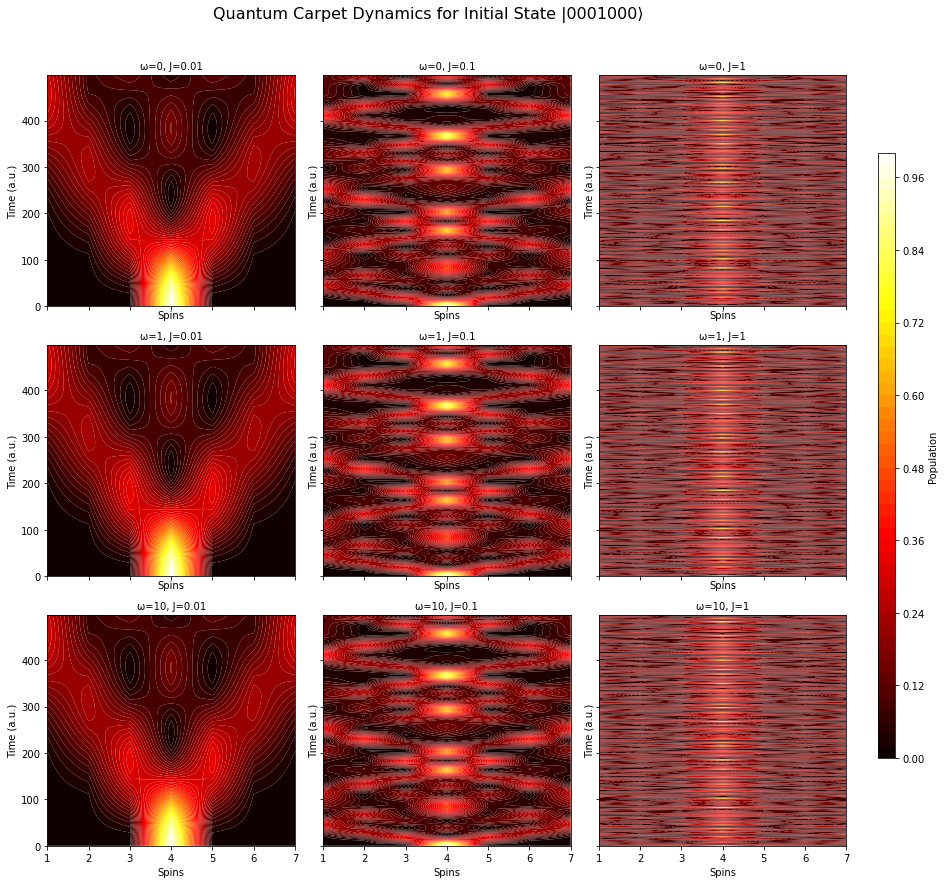

In [30]:
# Define the spin chain parameters
n_spin = 7           # Number of spins in the chain
N_time = 200         # Number of time steps
T = 500              # Total time
dt = T / N_time      # Time step

# Values of omega and J
omega_values = [0, 1, 10]
J_values = [0.01, 0.1, 1]


# Function to build an initial state
def buildstate(state_str):
    state = np.zeros(2**n_spin, dtype=complex)
    index = int(state_str, 2)
    state[index] = 1
    return state

# Initialize the population array
def compute_population(H, psi0, nspin):
    pop = np.zeros((N_time, nspin))  # Array to store population over time
    for i in range(N_time):
        t = i * dt
        psi_t = Dyn(H, t, psi0)  # Evolve the wavefunction
        rho_k = np.outer(psi_t, np.conj(psi_t))  # Full density matrix
        for k in range(nspin):
            pop[i, k] = rho_k[2**k, 2**k].real  # Only real part is stored
    return pop

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

# Generate quantum carpets
initial_state = buildstate('0001000')  # Initial state with excitation at site 4
for i, omega in enumerate(omega_values):
    for j, J in enumerate(J_values):
        H = Htot_XXX_open(n_spin, omega, J)
        pop = compute_population(H, initial_state, n_spin)

        ax = axs[i, j]
        c = ax.contourf(range(1, n_spin + 1), [k * dt for k in range(N_time)], pop, 
                        levels=np.linspace(0, 1, 51), cmap='hot', antialiased=True)
        ax.set_title(f'ω={omega}, J={J}', fontsize=10)
        ax.set_xlabel('Spins')
        ax.set_ylabel('Time (a.u.)')

fig.suptitle('Quantum Carpet Dynamics for Initial State |0001000⟩', fontsize=16, y=1.02)
        
# Adjust layout and add colorbar
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cbar_ax, label='Population')
plt.show()


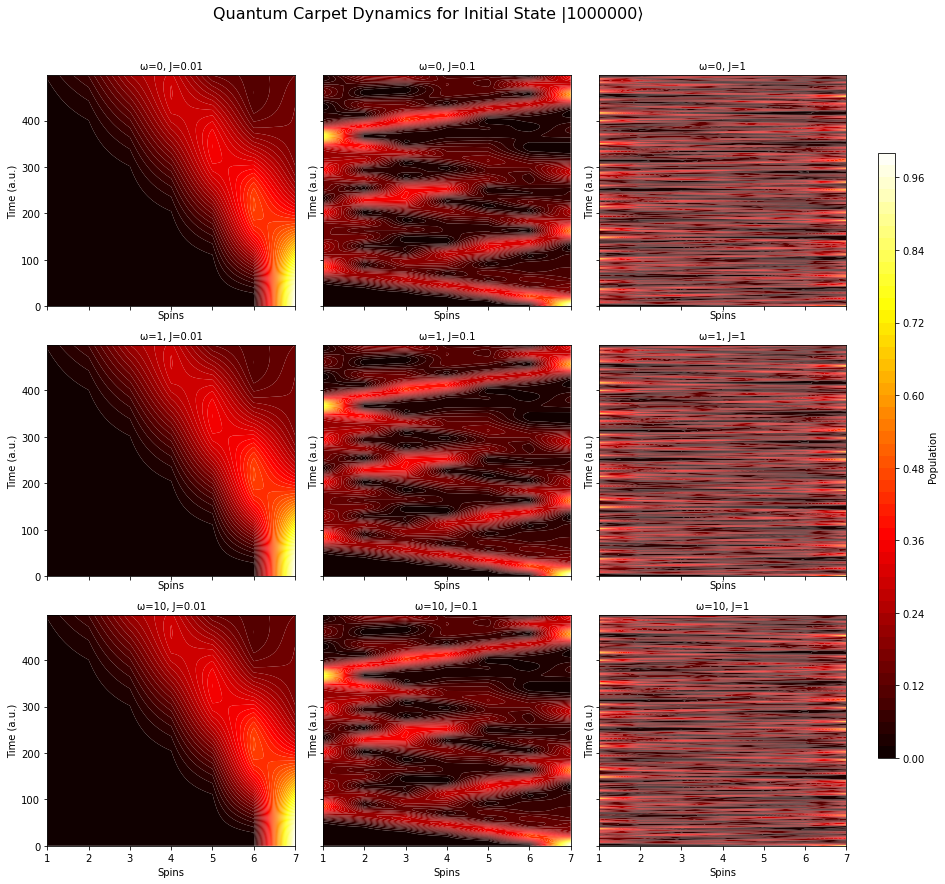

In [31]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

# Generate quantum carpets
initial_state = buildstate('1000000')  # Initial state with excitation at site 1
for i, omega in enumerate(omega_values):
    for j, J in enumerate(J_values):
        H = Htot_XXX_open(n_spin, omega, J)
        pop = compute_population(H, initial_state, n_spin)

        ax = axs[i, j]
        c = ax.contourf(range(1, n_spin + 1), [k * dt for k in range(N_time)], pop, 
                        levels=np.linspace(0, 1, 51), cmap='hot', antialiased=True)
        ax.set_title(f'ω={omega}, J={J}', fontsize=10)
        ax.set_xlabel('Spins')
        ax.set_ylabel('Time (a.u.)')

fig.suptitle('Quantum Carpet Dynamics for Initial State |1000000⟩', fontsize=16, y=1.02)

# Adjust layout and add colorbar
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cbar_ax, label='Population')
plt.show()



The behavior of each state has been described earlier but now let's study the influence of both parameter $J$ and $\omega$ :

- The exchange integral $J$, determines the strength of the interaction between neighboring spins in the chain. This interaction is responsible for the collective propagation of quantum excitations. A higher $J$ means stronger coupling between spins, leading to faster redistribution and diffusion of the population across the system. This can be compared to the spring constant $k$ in classical mechanics: a stiffer spring with a higher $k$ transfers energy more quickly and efficiently. In quantum carpet visualizations, increasing $J$ results in faster and broader spreading of the excitation along the chain.


- The Larmor frequency $\omega = \gamma B$ is a property of individual spins, describing their precession in an external magnetic field $B$. Unlike $J$, $\omega$ does not affect the collective diffusion dynamics of the system. It only influences the local evolution of individual spins, without altering the mechanism by which states are exchanged between neighboring spins. This can be compared to an oscillating force applied to a spring in classical mechanics: while it affects the motion of the individual mass, it does not alter the intrinsic properties of the spring, such as its stiffness.


- The quantum carpet visualizations show that the propagation speed of the excitation in the chain is solely determined by $J$, with no noticeable effect from $\omega$. This confirms that the process of state transfer is entirely governed by the interaction between neighboring spins, while the Larmor frequency does not influence the collective dynamics.


From our observations, we can conclude that $J$ plays a main role in the propagation of quantum excitations. On the other hand, $\omega$ only affects the local dynamics of spins and does not impact the global behavior of the system. 